In [11]:
import sys
sys.path.append("..")

import scipy
import pickle
import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol, sin, cos, tan, nsimplify
from sympy import MutableDenseMatrix, conjugate, Function, Symbol, diff, simplify, lambdify
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
# from optical_bloch.utils.general import flatten
# from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from optical_bloch_test.utils.general import flatten
from optical_bloch_test import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

In [12]:
hbar=1.054*1E-34; #[Js]
k_b=1.381*1E-23; #[J/K]
c=299792000; #[m/s]
eps_0=8.854*1E-12; #[F/m]
a0=5.29*1E-11; #[m]
q_e=1.602*1E-19; #[C]
Bohr_mag=1.39962449/1000*2*np.pi; #[GHz/G]

nground = 3
nexcite = 3
ntotal = 6

In [13]:
rabi_matrix = np.zeros([ntotal,ntotal,3])
rabi_matrix[:,:,0] = np.genfromtxt('rabimatrix33toy1.csv',delimiter=',')
rabi_matrix[:,:,1] = np.genfromtxt('rabimatrix33toy2.csv',delimiter=',')
rabi_matrix[:,:,2] = np.genfromtxt('rabimatrix33toy3.csv',delimiter=',')

In [59]:
E0 = Symbol(u'E0', real = True)
Ee = Symbol(u'Ee', real = True)

ω = Symbol(u'ω', real = True)
Ω = Symbol(u'Ω', real = True)
Δ = Symbol(u'Δ', real = True)
g = Symbol(u'g', real = True)

ϕ = Symbol(u'ϕ', real = True)
θ = Symbol(u'θ', real = True)
B = Symbol(u'B', real = True)
k = Symbol(u'k', real = True)
v = Symbol(u'v', real = True)
t = Symbol(u't', real = True)
x = v*t

In [60]:
ham = Hamiltonian(ntotal)
ham.addEnergies([E0-g*B,E0,E0+g*B,
                 Ee,Ee,Ee])
# ham.addEnergies([E0-2*g*B,E0-g*B,E0,E0+g*B, E0+2*g*B,
#                  Ee-g*B,Ee,Ee+g*B])

In [61]:
# θ = 30/180*np.pi
# ϕ = 1/4*np.pi

for i in range(nground):
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)**(-1)*np.sqrt(2)*cos(k*x-ϕ/2)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,0], ω)

        if rabi_matrix[i, j, 2] != 0:
            prefactor = -(-1)**(1)*np.sqrt(2)*cos(k*x+ϕ/2)
            ham.addCoupling(i, j, prefactor*Ω*rabi_matrix[i,j,2], ω)

In [62]:
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineEnergyDetuning(E0, Ee, Δ, ω)
DH = simplify(diff(ham.transformed,t)/v)

In [63]:
ham.transformed

Matrix([
[                         -B*g - 1.0*Δ,                                     0,                                     0,                                     0, -0.235702260395516*Ω*cos(k*t*v + ϕ/2),                                     0],
[                                    0,                                -1.0*Δ,                                     0, -0.235702260395516*Ω*cos(k*t*v - ϕ/2),                                     0, -0.235702260395516*Ω*cos(k*t*v + ϕ/2)],
[                                    0,                                     0,                           B*g - 1.0*Δ,                                     0, -0.235702260395516*Ω*cos(k*t*v - ϕ/2),                                     0],
[                                    0, -0.235702260395516*Ω*cos(k*t*v - ϕ/2),                                     0,                                     0,                                     0,                                     0],
[-0.235702260395516*Ω*cos(k*t*v + ϕ/2),        

In [64]:
ham.hamiltonian

Matrix([
[                                            -B*g + E0,                                                     0,                                                     0,                                                    0, -0.235702260395516*Ω*exp(1.0*I*t*ω)*cos(k*t*v + ϕ/2),                                                    0],
[                                                    0,                                                    E0,                                                     0, -0.235702260395516*Ω*exp(1.0*I*t*ω)*cos(k*t*v - ϕ/2),                                                    0, -0.235702260395516*Ω*exp(1.0*I*t*ω)*cos(k*t*v + ϕ/2)],
[                                                    0,                                                     0,                                              B*g + E0,                                                    0, -0.235702260395516*Ω*exp(1.0*I*t*ω)*cos(k*t*v - ϕ/2),                                                    0],
[   

In [65]:
transition_strengths=np.zeros([ntotal,ntotal]);
for i in range(ntotal):
    for f in range(ntotal):
        for p in range(3):
            transition_strengths[i,f]=transition_strengths[i,f]+rabi_matrix[i,f,p]**2

In [66]:
BR = np.zeros([ntotal, ntotal])
for i in range(ntotal):
    sums=0
    for f in range(ntotal):
        sums=sums+transition_strengths[i,f]
        
    for f in range(ntotal):
        BR[i,f]=transition_strengths[i,f]/sums
        
for i in range(nground):
    BR[i,:]=0

In [67]:
BR[nground:,:]

array([[0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. ]])

In [68]:
Γ = Symbol(u'Γ', real = True)
dis = Dissipator(ntotal)

for exct in tqdm(range(nground, ntotal)):
    for grnd in range(nground):
        if BR[exct, grnd] != 0:
            dis.addDecay(exct, grnd, Γ * BR[exct, grnd])

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


In [69]:
dis.dissipator

Matrix([
[ 0.5*Γ*(ρ₃₃(t) + ρ₄₄(t)),                        0,                        0,            -0.5*Γ*ρ₀₃(t),            -0.5*Γ*ρ₀₄(t), -0.5*Γ*ρ₀₅(t)],
[                       0,  0.5*Γ*(ρ₃₃(t) + ρ₅₅(t)),                        0,            -0.5*Γ*ρ₁₃(t),            -0.5*Γ*ρ₁₄(t), -0.5*Γ*ρ₁₅(t)],
[                       0,                        0,  0.5*Γ*(ρ₄₄(t) + ρ₅₅(t)),            -0.5*Γ*ρ₂₃(t),            -0.5*Γ*ρ₂₄(t), -0.5*Γ*ρ₂₅(t)],
[-0.5*Γ*conjugate(ρ₀₃(t)), -0.5*Γ*conjugate(ρ₁₃(t)), -0.5*Γ*conjugate(ρ₂₃(t)),            -1.0*Γ*ρ₃₃(t),            -1.0*Γ*ρ₃₄(t), -1.0*Γ*ρ₃₅(t)],
[-0.5*Γ*conjugate(ρ₀₄(t)), -0.5*Γ*conjugate(ρ₁₄(t)), -0.5*Γ*conjugate(ρ₂₄(t)), -1.0*Γ*conjugate(ρ₃₄(t)),            -1.0*Γ*ρ₄₄(t), -1.0*Γ*ρ₄₅(t)],
[-0.5*Γ*conjugate(ρ₀₅(t)), -0.5*Γ*conjugate(ρ₁₅(t)), -0.5*Γ*conjugate(ρ₂₅(t)), -1.0*Γ*conjugate(ρ₃₅(t)), -1.0*Γ*conjugate(ρ₄₅(t)), -1.0*Γ*ρ₅₅(t)]])

In [70]:
%%time
bloch = BlochEquations(ntotal, dis.density_matrix, ham.transformed, dis.dissipator)

start generateEquations
Wall time: 510 ms


In [71]:
from julia import Main

nprocs = 4 # number of processes to use for EnsembleDistributed 
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
end
""")

    
Main.eval("procs()")

array([1, 2, 3, 4], dtype=int64)

In [72]:
hamiltonian_symbols = ham.transformed.free_symbols
hamiltonian_symbols = [d for d in hamiltonian_symbols if str(d)[0] not in ['t']]
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = [d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']]
                      
lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);

    

# the code below is to transform the symbolic version of Sympy into a form usable with Julia
diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        hval = hval.replace('I','icomplex')
        print(hval)
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);

-B*g - 1.0*Δ
0
0
0
-0.235702260395516*Ω*cos(k*t*v + ϕ/2)
0
0
-1.0*Δ
0
-0.235702260395516*Ω*cos(k*t*v - ϕ/2)
0
-0.235702260395516*Ω*cos(k*t*v + ϕ/2)
0
0
B*g - 1.0*Δ
0
-0.235702260395516*Ω*cos(k*t*v - ϕ/2)
0
0
-0.235702260395516*Ω*cos(k*t*v - ϕ/2)
0
0
0
0
-0.235702260395516*Ω*cos(k*t*v + ϕ/2)
0
-0.235702260395516*Ω*cos(k*t*v - ϕ/2)
0
0
0
0
-0.235702260395516*Ω*cos(k*t*v + ϕ/2)
0
0
0
0


In [73]:
# Creating the system of equations
Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    @named bloch = ODESystem(eqns)
    tmp = 0
end
""");
Main.eval("@everywhere bloch = structural_simplify(bloch)");

In [74]:
# initial populations
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(nground):
    y0[_,_] = 1/nground
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [75]:
# constants setup
Main.eval("""
    @everywhere begin
    Bohr_mag=1.39962449/1000*2*pi
    c=299792000
    hbar=1.054E-34
    Γ_val = 1/33
    tmp =0;
end
""");

In [76]:
print(hamiltonian_symbols,dissipator_symbols)

[Δ, v, ϕ, B, k, Ω, g] [Γ]


In [77]:
# setting up the parameters of the model and initial conditions
Main.eval("""
    @everywhere begin
    p = [
    ϕ => pi/4,
    B => 0,
    k => 1,
    Δ => 2.5,
    Ω => 1,
    g => 0,
    Γ => 1,
    v => 0.1,
    icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [78]:
%%time
# creating the problem to solve
Main.eval("""
@everywhere begin
    tspan = (0., 5000.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

Wall time: 752 ms


Wall time: 2.01 s


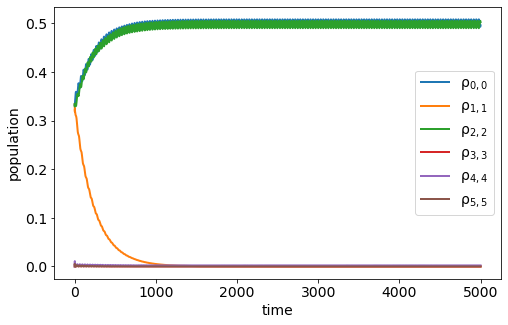

In [79]:
%%time
# solving the ODEProblem, keep in mind that the first run compiles called functions
# the first run will be significantly slower (due to compilation), but any subsequent solves are fast
Main.eval("@time sol = solve(prob, Tsit5())");
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t")
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [80]:
DH

Matrix([
[                                     0,                                      0,                                      0,                                      0, 0.235702260395516*k*Ω*sin(k*t*v + ϕ/2),                                      0],
[                                     0,                                      0,                                      0, 0.235702260395516*k*Ω*sin(k*t*v - ϕ/2),                                      0, 0.235702260395516*k*Ω*sin(k*t*v + ϕ/2)],
[                                     0,                                      0,                                      0,                                      0, 0.235702260395516*k*Ω*sin(k*t*v - ϕ/2),                                      0],
[                                     0, 0.235702260395516*k*Ω*sin(k*t*v - ϕ/2),                                      0,                                      0,                                      0,                                      0],
[0.235702260395516*k*Ω*

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:42<00:00,  1.41s/it]


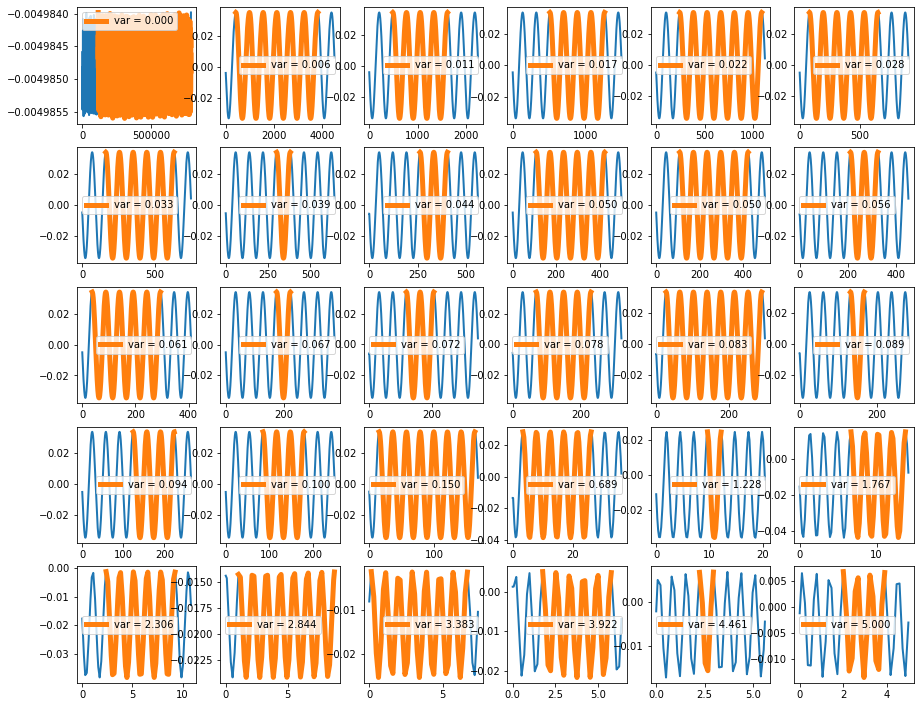

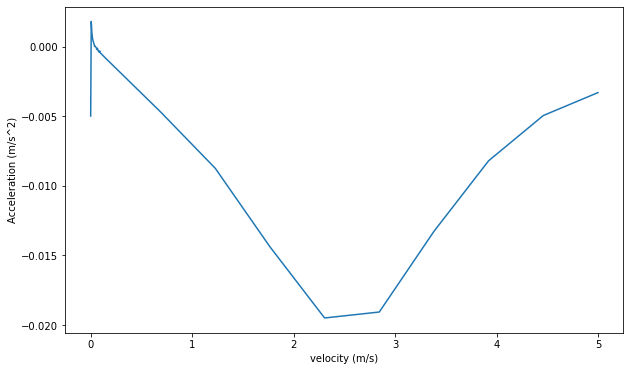

Wall time: 1min 41s


In [125]:
%%time
# varlist = np.linspace(0,5,30)
varlist = np.concatenate([np.linspace(0.,0.05,10),np.linspace(0.05,0.10,10),np.linspace(0.15,5,10)])


Main.params = varlist
Main.eval("@everywhere params = $params")
Main.eval("@everywhere Ω_val = sqrt(2)")
Main.eval("@everywhere phi_val = pi/8")
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        ϕ => phi_val,
        B => 1.,
        k => 1.,
        Δ => 2.5,
        Ω => Ω_val,
        g => 1.,
        Γ => 1.,
        v => params[i],
        icomplex => im
        ], parameters(bloch))
    tspan = (-5000., 5000*0.005/params[i])
   remake(prob, p = pnew, tspan = tspan)
end
""")
Main.eval("""
@everywhere function output_func(sol,i)
    ind = findmin(abs.(sol.t.-0.))[2]
    return [sol.t[ind:end],sol.u[ind:end]], false
end
""")
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true,reltol =1e-6)
sim.elapsedTime
""")
all_results = Main.eval("""sim.u""")

prefactor = 1
DH_new = prefactor*DH.subs([(k, 1.),(Ω, Main.Ω_val),(ϕ, Main.phi_val)])
δH = lambdify((v,t), DH_new, modules='numpy')
force_allvar = []
pltdim = int(np.sqrt(len(varlist))+1)
fig = plt.figure(figsize = (15,15))

for ind in tqdm(range(len(varlist))):
    t_array = all_results[ind][0]
    ρt = np.array(all_results[ind][1]).reshape(-1,ntotal,ntotal)
    ex_pop = np.array([np.sum([np.real(ρt[_,__,__]) for __ in range(nground,ntotal)]) for _ in range(len(t_array))])
    force_list = []
    for t_ind in range(len(t_array)):
        dH = δH(varlist[ind],t_array[t_ind])
        f_temp = -np.matmul(ρt[t_ind],dH)
        force = np.trace(np.real(f_temp))
        force_list.append(force)

    sample_size = 3000
    t_max = t_array[-1]
    t_interp = np.linspace(0,t_max,sample_size)
    force_interp = np.interp(t_interp,t_array,force_list)
    t_midind = int(sample_size/2)

    max_sig_ind_in_1 = np.argmax(force_interp[0:t_midind])
    max_sig_ind_in_2 = np.argmax(force_interp[t_midind:])+t_midind
    fig.add_subplot(pltdim,pltdim,ind+1)
    plt.plot(t_interp,force_interp,lw=2)
    plt.plot(t_interp[max_sig_ind_in_1:max_sig_ind_in_2],force_interp[max_sig_ind_in_1:max_sig_ind_in_2],lw=5,label = f'var = {varlist[ind]:.3f}')
    force_int = np.mean(force_interp[max_sig_ind_in_1:max_sig_ind_in_2])
    force_allvar.append(force_int)
    plt.legend()
plt.show()

plt.figure(figsize = (10,6))
plt.plot(varlist, force_allvar)
plt.xlabel('velocity (m/s)')
plt.ylabel('Acceleration (m/s^2)')
plt.show()


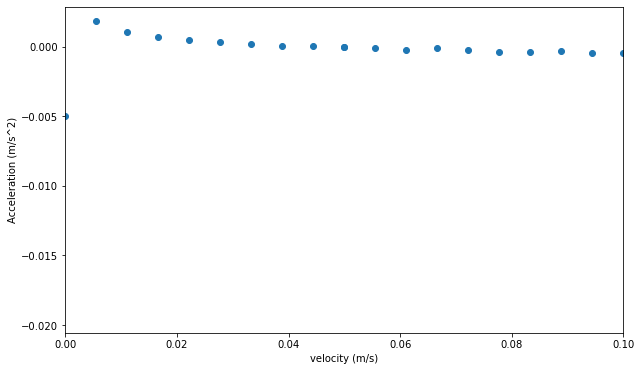

In [126]:
plt.figure(figsize = (10,6))
plt.plot(varlist, force_allvar,'o')
plt.xlabel('velocity (m/s)')
plt.ylabel('Acceleration (m/s^2)')
plt.xlim([0,0.1])
plt.show()

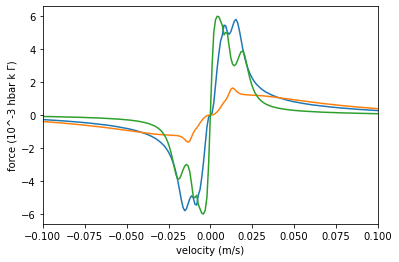

In [114]:
plt.figure(figsize = (6,4))
plt.plot(np.concatenate([-np.flip(varlist),varlist]), np.concatenate([-np.flip(np.array(force_allvar_pi_over_4)*1E3),np.array(force_allvar_pi_over_4)*1E3]))
plt.plot(np.concatenate([-np.flip(varlist),varlist]), np.concatenate([-np.flip(np.array(force_allvar_3pi_over_8)*1E3),np.array(force_allvar_3pi_over_8)*1E3]))
plt.plot(np.concatenate([-np.flip(varlist),varlist]), np.concatenate([-np.flip(np.array(force_allvar_pi_over_8)*1E3),np.array(force_allvar_pi_over_8)*1E3]))

plt.xlabel('velocity (m/s)')
plt.ylabel('force (10^-3 hbar k Γ)')
plt.xlim([-0.1,0.1])
plt.show()